## Sample 6.1 Multi-parameter Bayesian Model: Velocity distribution

In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)


# read a sample velocity data
y = np.loadtxt('Vlos.dat')


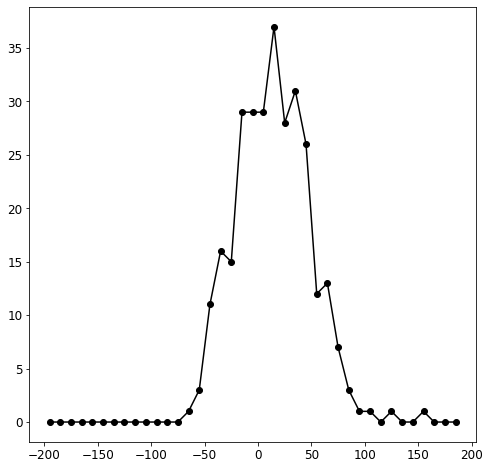

In [2]:
# draw histogram
vgrid = np.arange(-200,200,10)
vcenter = (vgrid[1:]+vgrid[:-1])/2.

hv,xedge = np.histogram(y,vgrid)

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.plot(vcenter, hv, 'ko-')
ax.set_label('V')

fig.show()

In [3]:
#ask for the mean velocity and the velocity dispersion, 
#providing that the velocity distributionis Gaussian
#known mean redshift ask dispersion, as homework
def logit(x):
    return np.log10(x/(1.-x))

def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x

def Scl_InvChi2ln(x, nu, s2):
    return InvGammaln(x, nu/2.,nu/2.*s2)

def randDraw_SInvChi2(nu,s2, N):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=0,high=2000,size=N*20)
        y0 = np.log(np.random.uniform(\
                    low=0,high=0.006,size=N*20))
        #x0 = logit(x0)
        y1 = Scl_InvChi2ln(x0, nu, s2)
        
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        #print k,m
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])

# sampling
n = len(y)
print(n)
y_bar = np.sum(y)/n #np.mean(y)
s2 = np.sum((y-y_bar)**2)/(n-1.) #np.var(y)
print(r'Data: y_bar = %(y).3f km/s,  s2 = %(s).3f km^2/s^2 s = %(s1).3f km/s' %\
     {'y':y_bar, 's':s2, 's1':np.sqrt(s2)})


294
Data: y_bar = 14.260 km/s,  s2 = 1162.481 km^2/s^2 s = 34.095 km/s


## step 1: draw sigma2 from posterior density of sigma2 given v, p(sigma2|y)

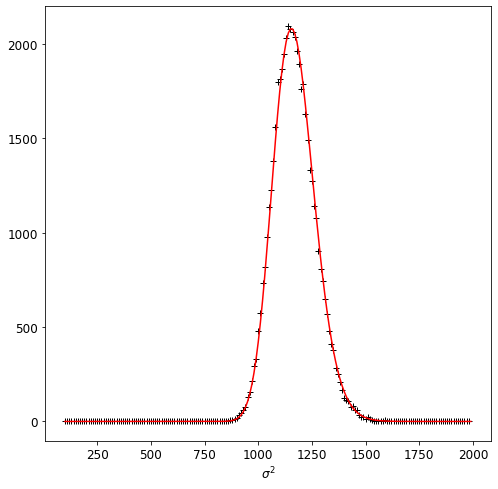

In [4]:
N = 50000
sigma2 = randDraw_SInvChi2(n-1,s2, N)

#draw the random draw of sigma
x = np.arange(100,2000,10)
y1 = np.exp(Scl_InvChi2ln(x, n-1, s2))
hy,xedge = np.histogram(sigma2,x)

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.plot(x[0:-1],hy,'k+')
ax.plot(x,y1/sum(y1)*sum(hy),'r')
ax.set_xlabel(r'$\sigma^2$',fontsize=12)
fig.show()

## step 2 : draw mu from p(mu|sigma2,y)

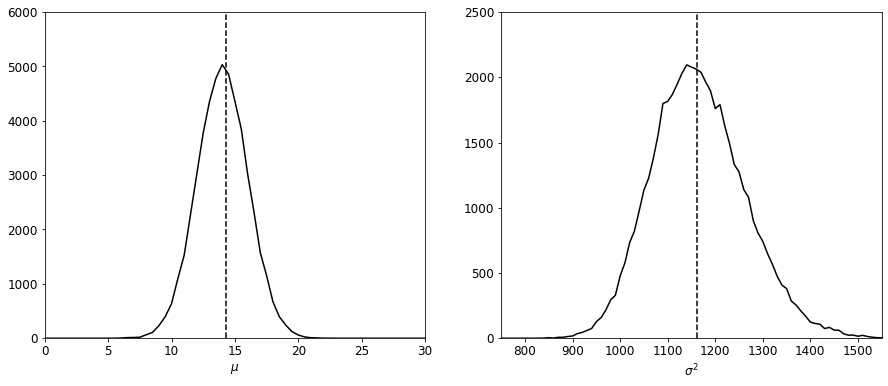

In [5]:

mu = np.random.normal(loc=y_bar, \
            scale=np.sqrt(sigma2/n))
#step 3: marginalize over sigma2
#draw the random draw of sigma
x = np.arange(-30,50,0.5)
hy,xedge = np.histogram(mu,x)
s = np.arange(500,2500,10)
hs,xedge = np.histogram(sigma2,s)

#draw the marginal density for mu
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(121)
ax.plot(x[0:-1],hy,'k')
ax.plot(y_bar*np.array([1.,1.]),[0.,10000.],'k--')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_xlim([0,30])
ax.set_ylim([0,6000])

#draw the marginal density for sigma
ax = fig.add_subplot(122)
ax.plot(s[0:-1],hs,'k')
ax.plot(s2*np.array([1.,1.]),[0.,5200.],'k--')
ax.set_xlabel(r'$\sigma^2$',fontsize=12)
ax.set_xlim([750,1550])
ax.set_ylim([0,2500])
fig.show()


In [6]:
#obtain the statistics from the sampling
print('mu = %(m).3f+/-%(s).3f' % \
    {'m': np.mean(mu), 's': np.std(mu)})
print('sigma = %(m).3f+/-%(s).3f' % \
    {'m': np.mean(np.sqrt(sigma2)), 's': np.std(np.sqrt(sigma2))})

mu = 14.266+/-1.998
sigma = 34.189+/-1.420


[Text(1, 26.0, ''),
 Text(1, 28.0, ''),
 Text(1, 30.0, ''),
 Text(1, 32.0, ''),
 Text(1, 34.0, ''),
 Text(1, 36.0, ''),
 Text(1, 38.0, ''),
 Text(1, 40.0, ''),
 Text(1, 42.0, '')]

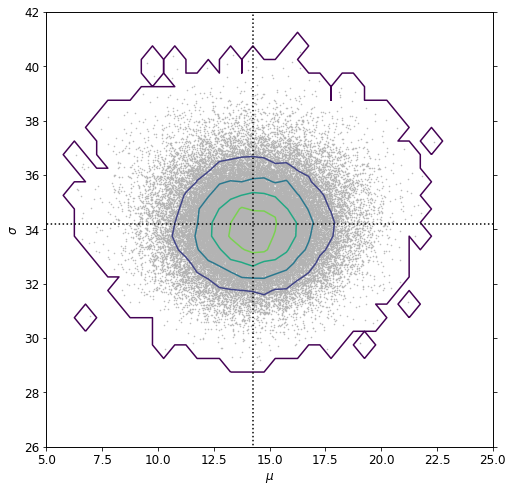

In [7]:
#draw joint posterior distribution for (mu, sigma)
xgrid = np.arange(-10,40,0.5)
ygrid = np.arange(25,45,0.5)
xcenter = (xgrid[:-1]+xgrid[1:])/2,
ycenter = (ygrid[:-1]+ygrid[1:])/2,
xmesh, ymesh = np.meshgrid(xcenter, ycenter)

hmusig,xedge,yedge = \
    np.histogram2d(mu.reshape((len(mu),)), \
    np.sqrt(sigma2.reshape((len(sigma2),))), \
    bins=[xgrid,ygrid])

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.plot(mu,np.sqrt(sigma2),'.',\
    color=[0.7,0.7,0.7],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,\
            extent=[xcenter[0],xcenter[-1],\
            ycenter[0],ycenter[-1]])
ax1.plot([np.mean(mu),np.mean(mu)],[0,100],'k:')
ax1.plot([-100,100],[np.mean(np.sqrt(sigma2)),\
            np.mean(np.sqrt(sigma2))],'k:')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=12)
ax.set_xlim([5,25])
ax.set_ylim([26,42])
ax1.set_xlim([5,25])
ax1.set_ylim([26,42])
ax1.set_yticklabels([])

# fig.show()

## consider a conjugate prior

/tmp/ipykernel_7074/2704383594.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.float(len(y))
/tmp/ipykernel_7074/2704383594.py:41: UserWarning: The following kwargs were not used by contour: 'color'
  ax1.contour(xmesh,ymesh,hmusig.T,6,\
/tmp/ipykernel_7074/2704383594.py:45: UserWarning: The following kwargs were not used by contour: 'color'
  ax1.contour(xmesh,ymesh,hmusig_c.T,6,\


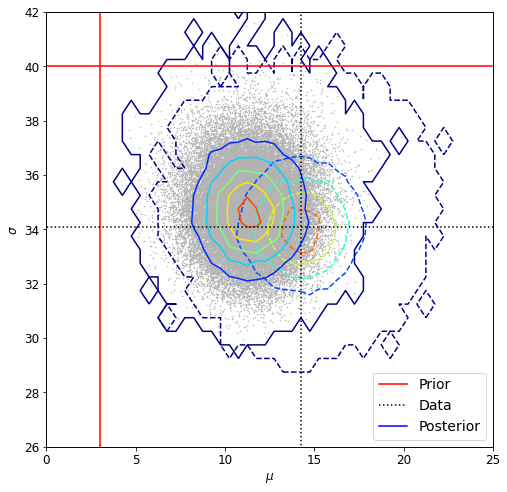

In [8]:

import matplotlib.lines as mlines
#parameters of prior
nu0 = 10.0
sigma02 = 40**2
kappa0 = 100
mu0 = 3.

n = np.float(len(y))
N = 50000

#sample mean and variance
y_bar = np.sum(y)/n
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+\
    kappa0*n*(y_bar-mu0)**2/(kappa0+n)

#step 1: sample sigma2
sigma2_c = randDraw_SInvChi2(nun,\
            nunsigman2/nun, N)
#step 2: sample mu
mu_c = np.random.normal(mun,np.sqrt(sigma2_c/kappan))

#draw joint distribution obtained 
# from the sampling
hmusig_c,xedge,yedge = np.histogram2d(\
    mu_c.reshape((len(mu_c),)), \
    np.sqrt(sigma2_c.reshape(\
        (len(sigma2_c),))), bins=[xgrid,ygrid])

fig = plt.figure(figsize=[8,8])
plt.set_cmap('jet')
ax = fig.add_subplot(111)
ax.plot(mu_c,np.sqrt(sigma2_c),'.',\
        color=[0.7,0.7,0.7],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,\
            linestyles='dashed',\
            color='r',extent=[xcenter[0],\
            xcenter[-1],ycenter[0],ycenter[-1]])
ax1.contour(xmesh,ymesh,hmusig_c.T,6,\
            color='k',extent=[xcenter[0],\
            xcenter[-1],ycenter[0],ycenter[-1]])
ct = mlines.Line2D([], [], color='blue')
e0,= ax1.plot([mu0,mu0],[0,100],'r-')
ax1.plot([-100,100],[np.sqrt(sigma02),\
            np.sqrt(sigma02)],'r-')
e1, =ax1.plot([y_bar,y_bar],[0,100],'k:')
ax1.plot([-100,100],[np.sqrt(s2),\
            np.sqrt(s2)],'k:')
plt.legend([e0,e1,ct],['Prior','Data','Posterior'],fontsize=14)
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=12)
ax.set_xlim([0,25])
ax.set_ylim([26,42])
ax1.set_xlim([0,25])
ax1.set_ylim([26,42])
ax1.set_yticks([])

fig.show()

## emcee 

/tmp/ipykernel_7074/2183695531.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.float(len(y))


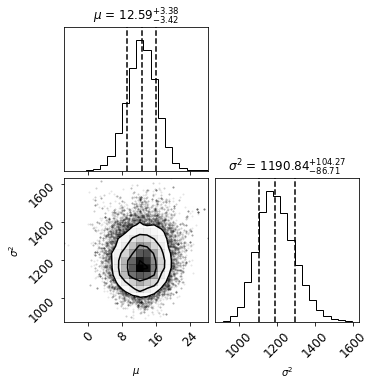

In [10]:
import emcee
import corner

def N_Scl_invChi2ln(x, mu,nu,kappa,sigma2):
    if x[1]<0:
        return -1e50
    else:
        return Scl_InvChi2ln(x[1],\
            nu,sigma2)+stats.norm.logpdf(x[0],\
            loc=mu, scale=x[1]/kappa)
    

n = np.float(len(y))

#sample mean and variance
y_bar = np.sum(y)/n
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the prior density
nu0 = 10.
sigma02 = 40**2
kappa0 = 50
mu0 = 3.
#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+kappa0*n*\
    (y_bar-mu0)**2/(kappa0+n)
sigman2 = nunsigman2/nun

ndim = 2

nwalkers = 50

p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*30.-15.
p0[:,1] = np.random.rand(nwalkers)*50.+10.
    
sampler = emcee.EnsembleSampler(nwalkers, \
    ndim, N_Scl_invChi2ln, \
    args=[mun,nun,kappan,sigman2])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

samples = sampler.chain[:, :, :].reshape((-1, ndim))

fig = corner.corner(samples,\
        labels=[r"$\mu$", r"$\sigma^2$"],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})


/tmp/ipykernel_7074/3135411076.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(x)*(-alpha-1)-beta/x
/tmp/ipykernel_7074/3135411076.py:18: RuntimeWarning: divide by zero encountered in true_divide
  np.log(x)*(-alpha-1)-beta/x
/tmp/ipykernel_7074/3135411076.py:17: RuntimeWarning: invalid value encountered in subtract
  return np.log(beta)*alpha-(special.gammaln(alpha))+\


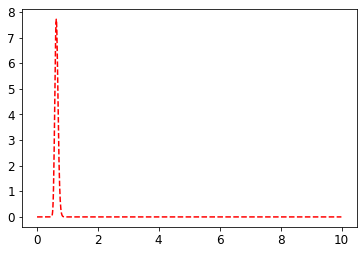

In [14]:
%matplotlib inline
'''
Demonstrate why we use log-Inv-Gamma rather than Inve-Gamma
'''
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

def InvGamma(x,alpha,beta):
    return beta**alpha/special.gamma(alpha)*\
           x**(-alpha-1)*np.exp(-beta/x)
    
def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x
    
alpha = 155.
beta = 100.
xgrid = np.arange(0,10,0.01)
#y = InvGamma(xgrid,alpha,beta)
lny = InvGammaln(xgrid,alpha,beta)

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(xgrid,y,'k-')
ax.plot(xgrid,np.exp(lny),'r--')

# fig.show()

In [15]:
'''
Demonstrate how to deal with extremely small numbers
'''
x1 = -1991.
x2 = -1993.
s = 0.1
y1 = np.exp(-x1/(2*s**2))
y2 = np.exp(-x2/(2*s**2))
print(y1/y2)
y1 = -x1/(2*s**2)
y2 = -x2/(2*s**2)
print((y1-y2))
print(np.exp(y1-y2+100))

nan
-100.0
1.0


/tmp/ipykernel_7074/3359342846.py:7: RuntimeWarning: overflow encountered in exp
  y1 = np.exp(-x1/(2*s**2))
/tmp/ipykernel_7074/3359342846.py:8: RuntimeWarning: overflow encountered in exp
  y2 = np.exp(-x2/(2*s**2))
/tmp/ipykernel_7074/3359342846.py:9: RuntimeWarning: invalid value encountered in double_scalars
  print(y1/y2)
